## Vertical stratification and submesoscale instabilities along the float tracks

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import math
import gsw
import metpy
import matplotlib as mpl
from astropy.convolution import convolve
from astropy.convolution import Box2DKernel
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [2]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [3]:
import src.importData as imports
import imp
import src.calc as calc
import src.stats as stats
import src.velocities as vel
import src.plots as plots
import src.settings as settings
import src.interpolation as interp
import src.concat as ct

In [4]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript', 'revision_figures')

In [5]:
# Import float data 
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

# Import satellite altimetry data 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [6]:
abs_vels = {}
rot_vels = {}

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
                       
for floatid in floatids:
    #absolute velocities
    file = os.path.join(datadir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file)
    
    #rotated velocities
    file = os.path.join(datadir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)

In [7]:
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'profile')
ds_dist = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance', rot_vels = rot_vels)

In [8]:
u_abs = {}
v_abs = {}
CT, SA = {}, {}
mld = {}

for floatid in floatids:
    # sub-inertial absolute velocities 
    u_abs[floatid], v_abs[floatid] = ds_dist[floatid].u_abs, ds_dist[floatid].v_abs
    
    # sub-inertial temperature and salinity
    CT[floatid] = ds_dist[floatid].CT
    SA[floatid] = ds_dist[floatid].SA
    mld[floatid] = calc.MLD_float(ds_dist[floatid], floatid, plot = False)
    

In [9]:
imp.reload(interp)
T_even_concat, T_smooth_concat, T_smooth, T_even_dist = interp.grid_and_smooth(CT, floatids)
S_even_concat, S_smooth_concat, S_smooth, S_even_dist = interp.grid_and_smooth(SA, floatids)

pdens = calc.potentialDensity(S_even_concat.pressure, S_even_concat, T_even_concat)
levels = np.arange(26.8,np.nanmax(pdens),0.1)

In [10]:
N2, f = {}, {}
N2_prof = {}
N2_even = {}
for floatid in floatids:
    N2[floatid] = calc.N2(CT[floatid], SA[floatid], ds_dist[floatid].latitude, smooth = False).interpolate_na(dim = 'distance', max_gap = 9)
    N2_prof[floatid] = calc.N2(CT[floatid], SA[floatid], ds[floatid].latitude, smooth = False)

    f[floatid] = gsw.f(ds_dist[floatid].latitude)
    N2_even[floatid] = interp.even_dist_grid(N2[floatid], 3)

In [11]:
pdens_even_d = {}
mld_even_d = {}

pdens_prof = {}
mld_prof = {}
for floatid in floatids:
    pdens_even_d[floatid] = calc.potentialDensity(T_even_dist[floatid].pressure, S_even_dist[floatid], T_even_dist[floatid])
    mld_even_d[floatid] = calc.MLD(pdens_even_d[floatid], criteria = 0.05, pref = 10)
    
    pdens_prof[floatid] = calc.potentialDensity(ds[floatid].pressure, ds[floatid].SA, ds[floatid].CT)
    mld_prof[floatid] = calc.MLD(pdens_prof[floatid], criteria = 0.05, pref = 10)

In [12]:
levels = np.arange(26.9,27.9,0.2)
vmin, vmax = -2e-5, 4e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

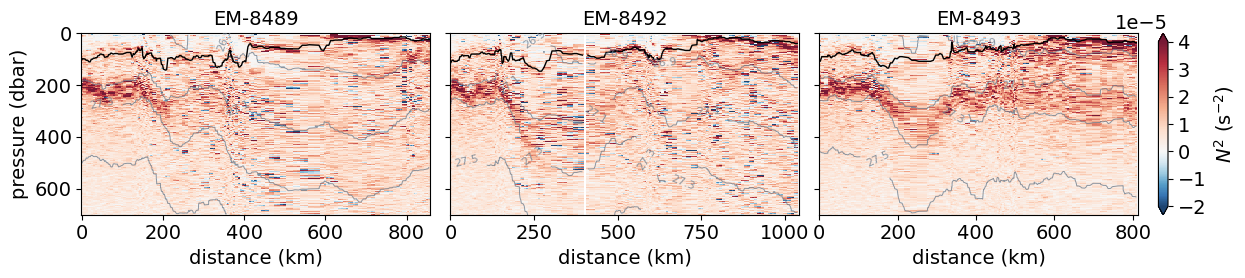

In [13]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3))
axs = ax.flatten()

i = 0
for floatid in floatids:
    pdens_dist = calc.potentialDensity(ds_dist[floatid].pressure, ds_dist[floatid].SA, ds_dist[floatid].CT)
    
    im = N2[floatid].plot(ax = axs[i], x = 'distance',  cmap = 'RdBu_r', vmin = vmin, vmax = vmax, 
                               norm = norm, alpha = 0.9, add_colorbar = False)
    
    mld[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_dist.plot.contour(ax = axs[i], x = 'distance', colors = 'slategrey', linewidths = 0.7, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,700)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$N^{2}$ (s$^{-2}$)', extend = 'both')

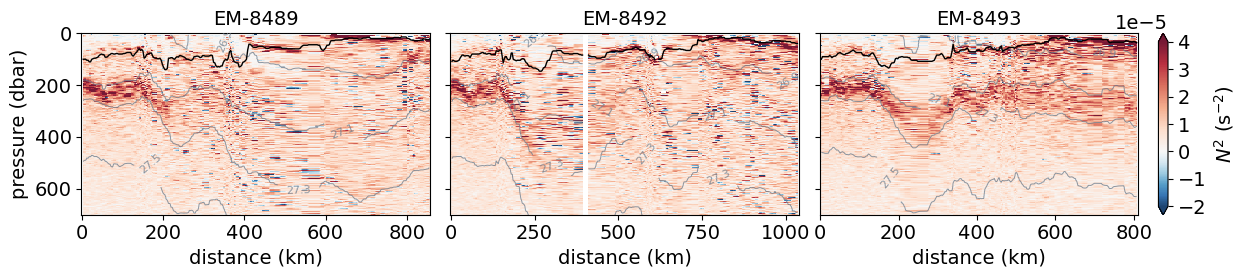

In [14]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = N2_even[floatid].plot(ax = axs[i], x = 'distance',  cmap = 'RdBu_r', vmin = vmin, vmax = vmax, 
                               norm = norm, alpha = 0.9, add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'slategrey', linewidths = 0.7, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,700)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$N^{2}$ (s$^{-2}$)', extend = 'both')

In [2085]:
# settings.save_figure(fig, my_path, 'N2.png', dpi = 600, pad = 0.2)

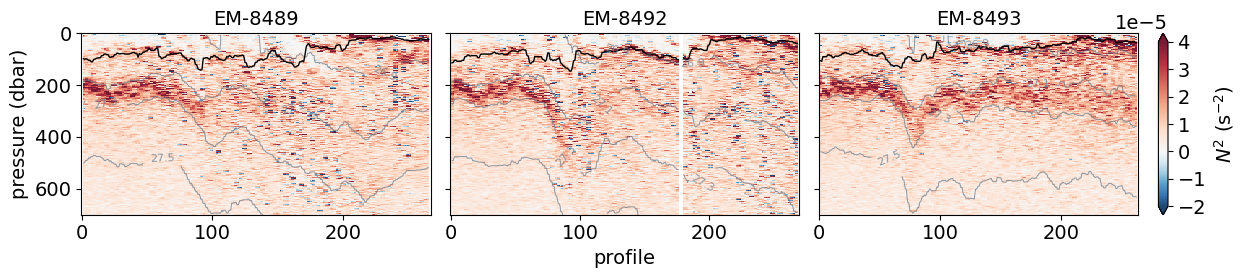

In [13]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = N2_prof[floatid].plot(ax = axs[i], x = 'profile',  cmap = 'RdBu_r', vmin = vmin, vmax = vmax, 
                               norm = norm, alpha = 0.9, add_colorbar = False)
    
    mld_prof[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_prof[floatid].plot.contour(ax = axs[i], x = 'profile', colors = 'slategrey', linewidths = 0.7, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,700)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('profile')

plt.tight_layout(w_pad = 0.7)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$N^{2}$ (s$^{-2}$)', extend = 'both')

In [1874]:
# settings.save_figure(fig, my_path, 'N2_prof.png', dpi = 600, pad = 0.2)

13
13


Text(0.05, 0.05, '13 profiles')

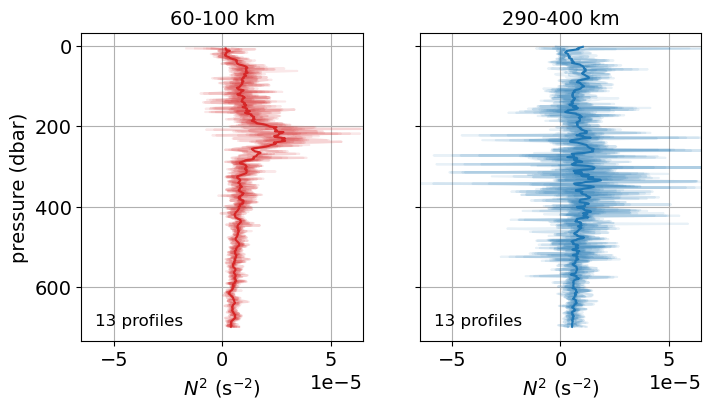

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8,4))

highN2 = N2[8492].sel(pressure = slice(0,700), distance = slice(60,100))
print(len(highN2))

for i in range(0, len(highN2)):
    highN2[i].plot(ax = ax1, y = 'pressure', alpha = 0.1, c = 'tab:red')

highN2.mean(dim = 'distance').rolling(pressure = 5,center = True, min_periods = 3).mean().plot(ax = ax1, y = 'pressure', 
                                                                                               c = 'tab:red')
ax1.invert_yaxis()
ax1.set_xlabel('$N^{2}$ (s$^{-2}$)')
ax1.set_ylabel('pressure (dbar)')
ax1.set_title('60-100 km', fontsize = 14)
ax1.grid()
ax1.set_xlim(-6.5e-5, 6.5e-5)
ax1.text(0.05, 0.05, f'{len(highN2)} profiles', fontsize = 12, transform = ax1.transAxes)

lowN2 = N2[8492].sel(pressure = slice(0,700), distance = slice(290,400))
print(len(lowN2))

for i in range(0, len(lowN2)):
    lowN2[i].plot(ax = ax2, y = 'pressure', alpha = 0.1, c = 'tab:blue')

lowN2.mean(dim = 'distance').rolling(pressure = 5,center = True, min_periods = 3).mean().plot(ax = ax2, y = 'pressure', 
                                                                                              c = 'tab:blue')

ax2.set_title('290-400 km', fontsize = 14)
ax2.set_xlabel('$N^{2}$ (s$^{-2}$)')
ax2.set_ylabel('')
ax2.grid()
ax2.text(0.05, 0.05, f'{len(lowN2)} profiles', fontsize = 12, transform = ax2.transAxes)

### Richardson number

In [15]:
imp.reload(calc)

Ri = {}
Ri_even_d = {}
Ri_prof = {}

shear_even_d = {}
shear_prof = {}

for floatid in floatids:
    Ri_num, shear = calc.RiNumber(N2[floatid], lat = ds_dist[floatid].latitude, u = ds_dist[floatid].u_abs, v = ds_dist[floatid].v_abs, 
                                                   smooth_vels = True, window = 15)
    
    Ri[floatid] = Ri_num.interpolate_na(dim = 'distance', max_gap = 9)
    shear = shear.interpolate_na(dim = 'distance', max_gap = 9)
    
    Ri_prof[floatid] = xr.DataArray(Ri[floatid].data, dims = ['profile', 'pressure'], coords = ds[floatid].u_abs.coords)
    shear_prof[floatid] = xr.DataArray(shear.data, dims = ['profile', 'pressure'], coords = ds[floatid].u_abs.coords)
    
    Ri_even_d[floatid] = interp.even_dist_grid(Ri[floatid], 3).rolling(distance = 3, center = True, min_periods = 1).mean()
    shear_even_d[floatid] = interp.even_dist_grid(shear, 3).rolling(distance = 3, center = True, min_periods = 1).mean()

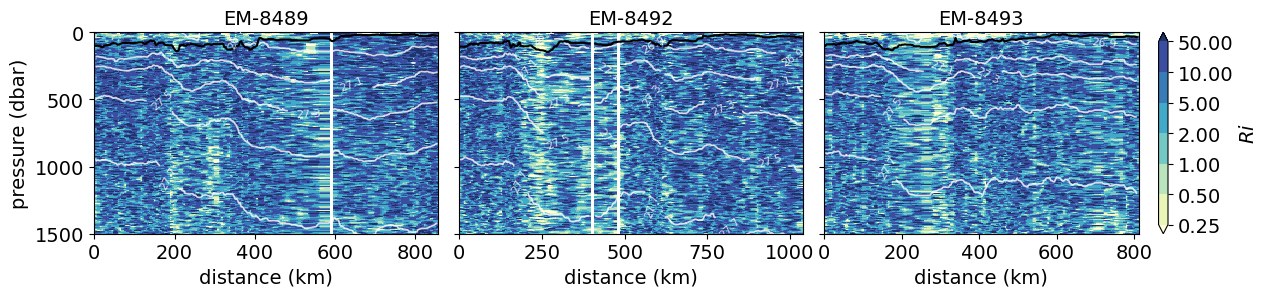

In [16]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = Ri_even_d[floatid].plot(ax = axs[i], x = 'distance', cmap = 'YlGnBu', levels = np.asarray([0.25, 0.5, 1, 2, 5, 10, 50]),
                               alpha = 0.9, add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1.5)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'w', linewidths = 1.2, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1500)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$Ri$', extend = 'both')

In [2081]:
# settings.save_figure(fig, my_path, 'Ri.png', dpi = 600, pad = 0.2)

Text(0.5, 1.0, 'EM-8493')

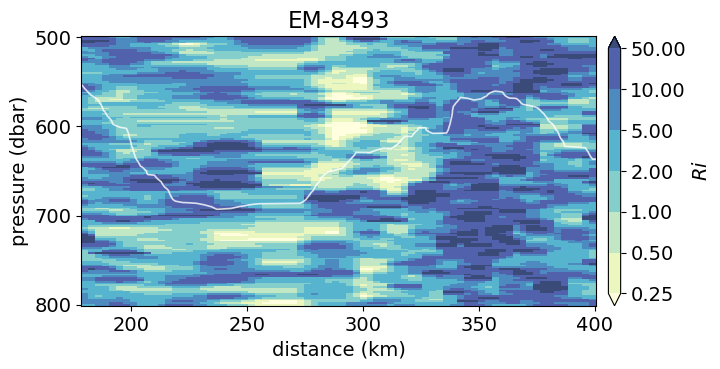

In [17]:
floatid = 8493

p1, p2 = 500, 800 #800, 1100
d1, d2 = 180, 400 #180,400

fig, ax = plt.subplots(figsize = (8,3.5))

Ri_even_d[floatid].sel(pressure = slice(p1, p2), distance = slice(d1, d2)).plot(x = 'distance', cmap = 'YlGnBu', 
                                                                levels = np.asarray([0.25, 0.5, 1, 2, 5, 10, 50]), 
                                    alpha = 0.8, cbar_kwargs = dict(label = '$Ri$', pad = 0.02,))

mld_even_d[floatid].plot(c = 'k', linewidth = 1)

CS = pdens_even_d[floatid].plot.contour(x = 'distance', colors = 'w', linewidths = 1.2, 
                                        levels = levels, alpha = 0.8)

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
plt.title(f'EM-{floatid}')

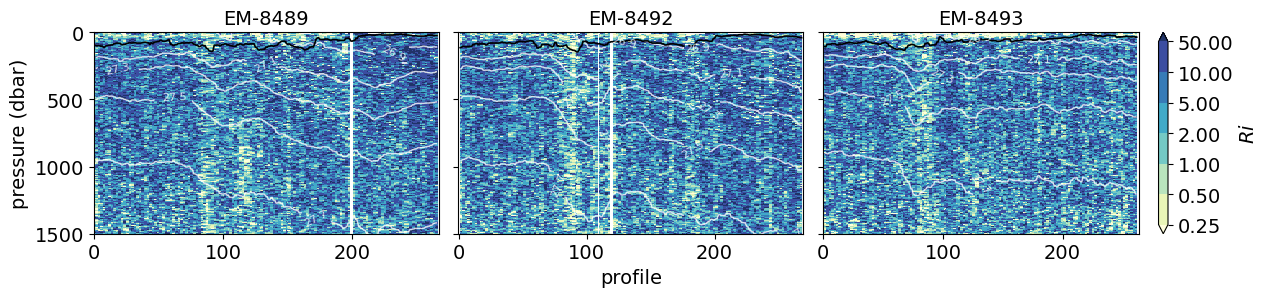

In [18]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = Ri_prof[floatid].plot(ax = axs[i], x = 'profile', cmap = 'YlGnBu', levels = np.asarray([0.25, 0.5, 1, 2, 5, 10, 50]),
                               alpha = 0.9, add_colorbar = False)
    
    mld_prof[floatid].plot(ax = axs[i], c = 'k', linewidth = 1.2)
    
    CS = pdens_prof[floatid].plot.contour(ax = axs[i], x = 'profile', colors = 'w', linewidths = 1, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1500)

    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('profile')

plt.tight_layout(w_pad = 0.7)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$Ri$', extend = 'both')

In [2062]:
# settings.save_figure(fig, my_path, 'Ri_prof.png', dpi = 600, pad = 0.2)

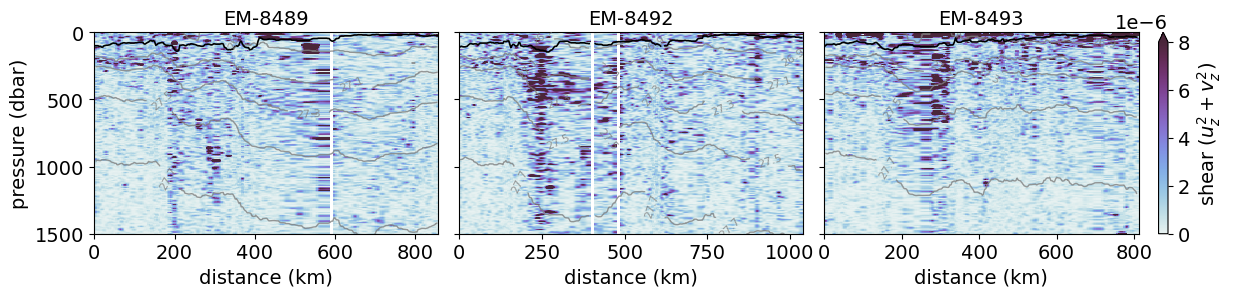

In [19]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = shear_even_d[floatid].plot(ax = axs[i], x = 'distance', cmap = cmocean.cm.dense, vmin = 0, vmax = 0.8e-5,
                               alpha = 0.9, add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1.2)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'grey', linewidths = 1, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1500)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'shear $(u_{z}^{2} + v_{z}^{2})$', extend = 'max')

Text(0.5, 0, 'profile')

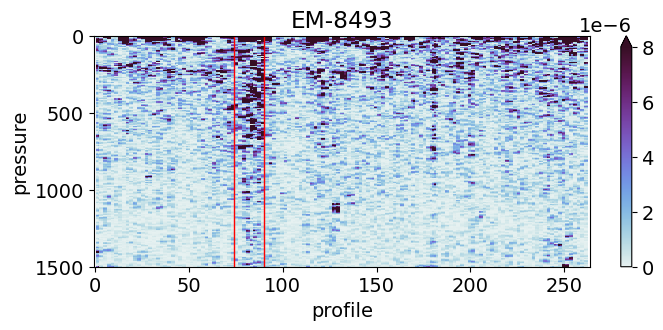

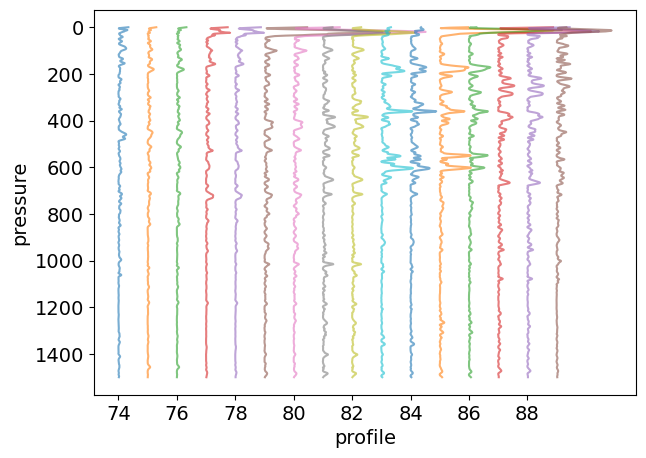

In [20]:
floatid = 8493
prof = 74
prof2 = prof + len(np.arange(0, 8e-4, 1e-4))*2

fig, ax = plt.subplots(figsize = (8,3))
shear_prof[floatid].sel(pressure = slice(0,1500)).plot(x = 'profile', cmap = cmocean.cm.dense, vmin = 0, vmax = 0.8e-5)
plt.axvline(x = prof, c = 'red', linewidth = 1)
plt.axvline(x = prof2, c = 'red', linewidth = 1)
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

fig, ax = plt.subplots(figsize = (7,5))
for i in range(len(shear_prof[floatid][prof:prof2])):
    (shear_prof[floatid][prof:prof2][i] + i/2e+4).sel(pressure = slice(0,1500)).plot(y = 'pressure', alpha = 0.6)
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 8e-4, 1e-4))
ax.set_xticklabels(np.arange(prof, prof2, 2).astype('str'))
plt.xlabel('profile')

In [2083]:
# settings.save_figure(fig, my_path, 'shear.png', dpi = 600, pad = 0.2)

Text(0.05, 0.05, '10 profiles')

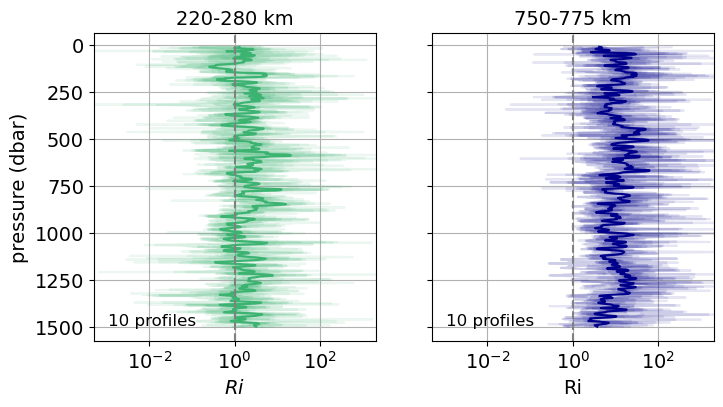

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8,4))

Ri_1 = Ri[8492].sel(pressure = slice(0,1500), distance = slice(220,280))

for i in range(0, len(Ri_1)):
    Ri_1[i].plot(ax = ax1, y = 'pressure', alpha = 0.1, c = 'mediumseagreen')

Ri_1.median(dim = 'distance').rolling(pressure = 5,center = True, min_periods = 3).mean().plot(ax = ax1, y = 'pressure', 
                                                                                               c = 'mediumseagreen')

ax1.axvline(x = 1, linestyle = '--', c = 'grey')
ax1.invert_yaxis()
ax1.set_xlabel('$Ri$')
ax1.set_ylabel('pressure (dbar)')
ax1.set_title('220-280 km', fontsize = 14)
ax1.grid()
ax1.set_xlim(0.0005, 2000)
ax1.set_xscale('log')
ax1.text(0.05, 0.05, f'{len(Ri_1)} profiles', fontsize = 12, transform = ax1.transAxes)

highRi = Ri[8492].sel(pressure = slice(0,1500), distance = slice(750,775))

for i in range(0, len(highRi)):
    highRi[i].plot(ax = ax2, y = 'pressure', alpha = 0.1, c = 'darkblue')

highRi.median(dim = 'distance').rolling(pressure = 5,center = True, min_periods = 3).mean().plot(ax = ax2, y = 'pressure', 
                                                                                              c = 'darkblue')
ax2.axvline(x = 1, linestyle = '--', c = 'grey')
ax2.set_title('750-775 km', fontsize = 14)
ax2.set_xlabel('Ri')
ax2.set_ylabel('')
ax2.grid()
ax2.text(0.05, 0.05, f'{len(highRi)} profiles', fontsize = 12, transform = ax2.transAxes)

# settings.save_figure(fig, my_path, 'Ri_EM8492_example_profiles.png', dpi = 600, pad = 0.2)

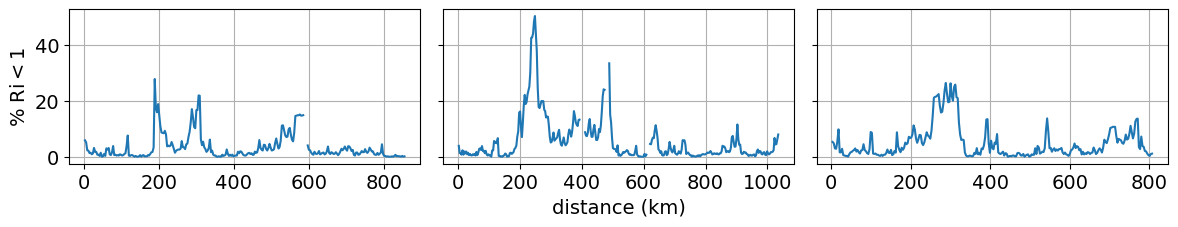

In [22]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 2.5))
axs = ax.flatten()

i = 0
for floatid in floatids:
    lowRi = stats.percent_below_mL(Ri_even_d[floatid], mld_even_d[floatid], condition = '<= 1', zmax = 1500, dim = 'pressure')
#     negN2 = stats.percent_below_mL(N2[floatid], mld[floatid], condition = '< -1e-6', zmax = 1500, dim = 'pressure')
#     shear_mean = calc.mean_below_ml(shear_even_d[floatid], mld_even_d[floatid], zmax = 1500, zdim = 'pressure')

    axs[i].plot(Ri_even_d[floatid].distance, lowRi)
    axs[i].grid()
    
    i+=1
    
axs[0].set_ylabel(u'% Ri$<$1')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.7)